In [1]:
#The goal of this project are: 
#1. to perform data cleaning and do comprehensive data analysis
#2. to creat and test models which are well trained to predict sale prices of the houses



In [2]:
# Importing necessary libraries 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost
import warnings
warnings.filterwarnings('ignore')

In [3]:
#loading the the training dataset
train_df = pd.read_csv('train.csv')

In [4]:
# Taking a view at our training dataset
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Figuring out how many features are categorical and numeric
train_df.get_dtype_counts()

float64     3
int64      35
object     43
dtype: int64

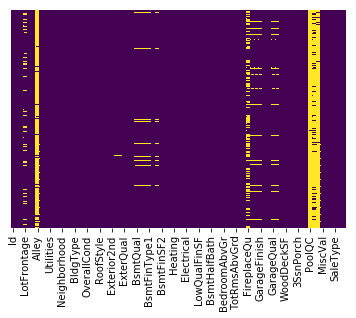

In [6]:
# 1. Data Cleaning
# with the help of heatmap seeing which features have more missing values
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [7]:
# calculating the percentage of missing values, so we can think if that feature is worth to keep for analysis.
null_count = train_df.isnull().sum().sort_values(ascending = False)
null_percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing_value = pd.concat([null_count, null_percent ], axis = 1)
missing_value.head(20)

,0,1
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


In [8]:
# droping those features which are having close to or more than 50% of data as missing values
train_df.drop(['Id', 'FireplaceQu', 'MiscFeature', 'Alley', 'Fence','FireplaceQu', 'PoolQC' ], axis = 1, inplace = True)

In [9]:
train_df.isnull().sum().sort_values(ascending = False).sort_values(ascending = False).head(5)

LotFrontage    259
GarageType      81
GarageYrBlt     81
GarageCond      81
GarageQual      81
dtype: int64

In [10]:
# since these features are categorical in nature but prersent in numeric values. Hence conveting then into string type.
train_df['MSSubClass'] = train_df['MSSubClass'].apply(str)
train_df['YrSold'] = train_df['YrSold'].astype(str)
train_df['MoSold'] = train_df['MoSold'].astype(str)

In [11]:
# this function will replace the missing values for categorical feature with the most frequent category of that column, 
# and for numeric features with the mean of that column
def missing_value_impute(df):
    miss_sum = df.isnull().sum()
    miss_list = miss_sum[miss_sum > 0]
    
    for feature in list(miss_list.index):
        
        if df[feature].dtype == 'object':
            df[feature].fillna(df[feature].mode().index[0], inplace=True)
            
        elif df[feature].dtype != 'object':
            df[feature].fillna(df[feature].mean(), inplace=True)

In [12]:
#applyin that function on our training data
missing_value_impute(train_df)

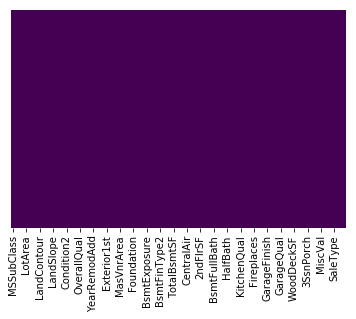

In [13]:
# rechecking if we have left any missing value
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [14]:
train_df.isnull().sum().sort_values(ascending = False).head(5)

SalePrice       0
YearRemodAdd    0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
dtype: int64

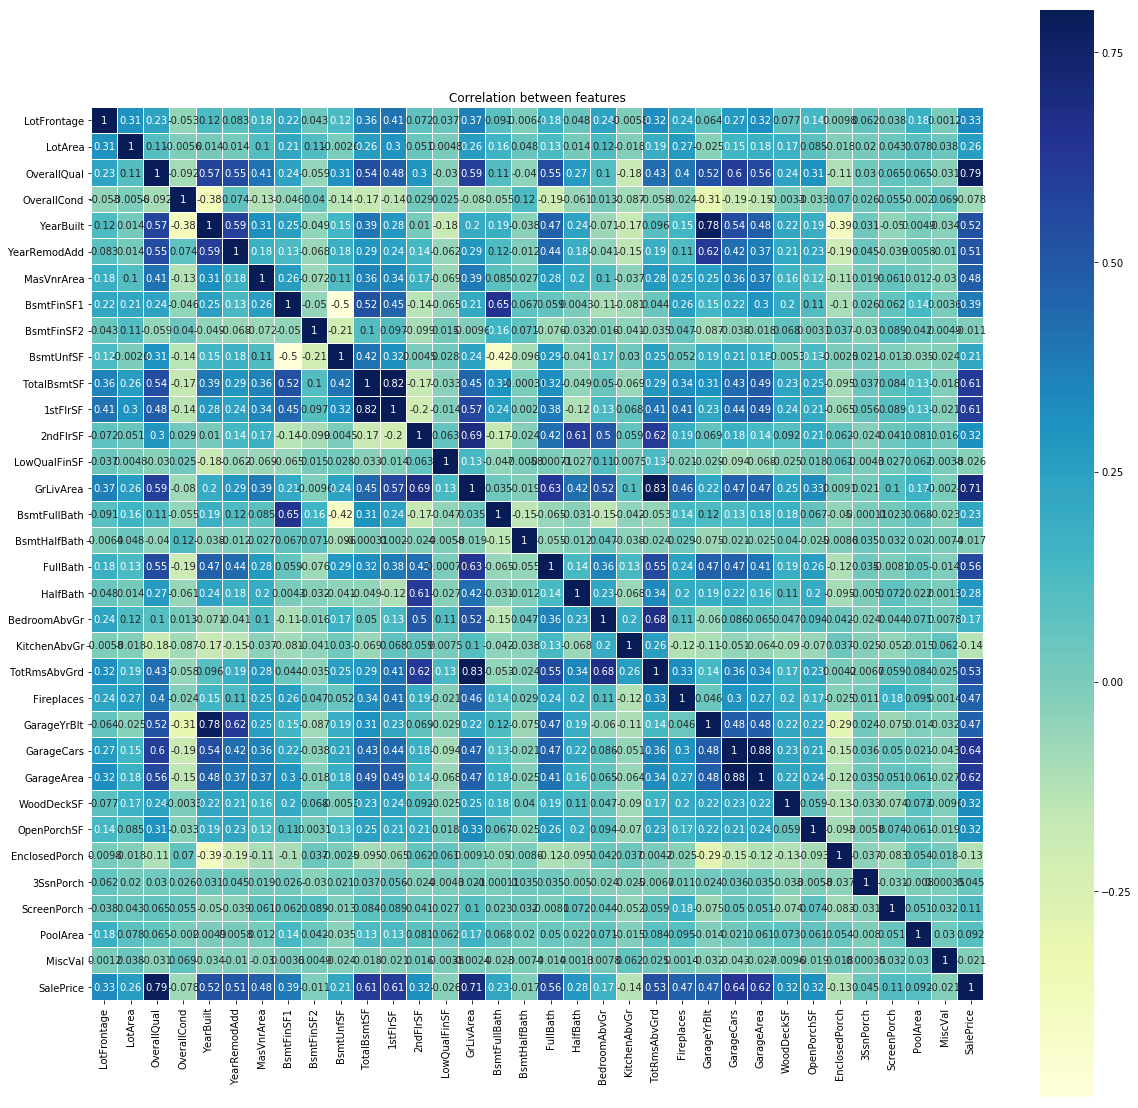

In [15]:
# checking the correlation among the features
corr=train_df.corr()
plt.figure(figsize= (20,20))
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [16]:
# Here we are loading our cleaned test dataset.
# the reason we are loading test dataset is beacause after analysis we have figured out that the number of categories in some of
# the features are different in train and test data set.
test_df= pd.read_csv('test_procs.csv')
test_df.head(5)
test_df.shape

(1459, 74)

In [17]:
# There are 75 columns in train dataset, because there is target feature 'Saleprice' is present here.
train_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [18]:
# Making a final dataset for feature engineering by joing test and train datasets.
final_df = pd.concat([train_df, test_df], axis = 0)
final_df.shape

(2919, 75)

In [19]:
final_df.SalePrice.tail(5)

1454   NaN
1455   NaN
1456   NaN
1457   NaN
1458   NaN
Name: SalePrice, dtype: float64

In [20]:
# Making a list of only categorical features for OneHotEncoding
df_object = final_df.dtypes == object
categorical_col = final_df.columns[df_object].tolist()
categorical_col

['BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'ExterCond',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Foundation',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSSubClass',
 'MSZoning',
 'MasVnrType',
 'MoSold',
 'Neighborhood',
 'PavedDrive',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street',
 'Utilities',
 'YrSold']

In [21]:
new_df = final_df[['MSZoning', 'Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood', 'Condition2','BldgType','Condition1','HouseStyle','SaleType', 'SaleCondition','ExterCond', 'ExterQual','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2', 'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Heating','HeatingQC', 'CentralAir', 'Electrical','KitchenQual','Functional', 'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive']]
new_df.head(5)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition2,BldgType,...,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,...,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Norm,1Fam,...,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,...,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,1Fam,...,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,1Fam,...,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y


In [22]:
# perofrming OneHotEncoding on categorical features of the dataset.
# To avoid the dummy variable trap, we are dropping the first dummy variable columns.
temp_df = pd.concat([pd.get_dummies(new_df[col], drop_first = True) for col in new_df], axis=1)
temp_df.shape

(2919, 207)

In [23]:
# dropping the original columns for which we have created dummy variables
for col in categorical_col:
    final_df.drop([col], axis = 1, inplace= True)

In [24]:
final_df.shape

(2919, 34)

In [25]:
# finally concatinating our dummy variable with our original dataset
onehot_df = pd.concat([final_df, temp_df], axis = 1)
onehot_df.shape

(2919, 241)

In [26]:
onehot_df.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,Gd,Po,TA,Ex,Fa,Gd,Po,TA,P,Y
0,856,854,0,3,706.0,0.0,1.0,0.0,150.0,0,...,0,0,1,0,0,0,0,1,0,1
1,1262,0,0,3,978.0,0.0,0.0,1.0,284.0,0,...,0,0,1,0,0,0,0,1,0,1
2,920,866,0,3,486.0,0.0,1.0,0.0,434.0,0,...,0,0,1,0,0,0,0,1,0,1
3,961,756,0,3,216.0,0.0,1.0,0.0,540.0,272,...,0,0,1,0,0,0,0,1,0,1
4,1145,1053,0,4,655.0,0.0,1.0,0.0,490.0,0,...,0,0,1,0,0,0,0,1,0,1


In [27]:
# Dropping all the duplicate columns
onehot_df =onehot_df.loc[:,~onehot_df.columns.duplicated()]
onehot_df.shape

(2919, 181)

In [28]:
# since we have created dummy variable for every category of every feau=ture, lets seperate back our train and test dataset.
train_set = onehot_df.iloc[:1451, :]
test_set = onehot_df.iloc[1451:, :]

In [29]:
test_set = test_set.drop(['SalePrice'], axis =1)
test_set.shape

(1468, 180)

In [30]:
# Seperating out target and predictor variables for model training
X_train=train_set.drop(['SalePrice'],axis=1)
y_train=train_set['SalePrice']

In [31]:
# Model Creation
# Random Forest Regression will be the first model to predict hous sale price.

RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [32]:
# Since we are going to perform the hyperparameter tuning for this model.
# Hence creating a matix of parameters to train our model.

bootstrap=  [True, False]
max_depth= [2, 3, 5, 10, None]
max_features = ['auto', 'sqrt']
min_samples_leaf= [1, 2, 4]
min_samples_split= [2, 5, 10]
n_estimators= [50, 100, 200, 300, 500, 700]


In [33]:
forest_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [37]:
# Using the RandomizedSearchCV for hyper-parameter tuning
RF_rdcv = RandomizedSearchCV(estimator=RF_model,
            param_distributions=forest_grid,
            cv=5, n_iter=10,
            scoring = 'neg_mean_absolute_error', verbose = 3, n_jobs = -1,
            return_train_score = True,
            random_state=42)

In [38]:
RF_rdcv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, score=(train=-19889.648, test=-20508.558), total=   0.4s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, score=(train=-19467.274, test=-23414.534), total=   0.4s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, score=(train=-19502.315, test=-22977.227), total=   0.4s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, score=(train=-20296.251, test=-20928.366), total=   0.4s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, score=(train=-19354.597, test=-23007.696), total=   0.4s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, score=(train=-5756.427, t

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=None,
                                                   oob_score=False,
                                                   random_state=N...


In [39]:
# With the help of best estimator we can have a set of parametes which give the best score.
RF_rdcv.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [40]:
# Retraining our model on the best parameters possible
RF_model = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
RF_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [41]:
# Predicting the sale price of houses in the test dataset.
RF_pred = RF_model.predict(test_set)
RF_df = pd.DataFrame(RF_pred, columns = ['RF_pred'])
RF_df.head()

,RF_pred
0,243395.605462
1,145905.720047
2,139101.020819
3,183196.526824
4,179526.817199


In [42]:
# cheacking the score of out model performance
RF_model.score(X_train, y_train)

0.9837955925511445

In [43]:
# XGBoost regression will be our second model to predict the sale prices of the houses

XGB_model=xgboost.XGBRegressor(objective ='reg:squarederror')
XGB_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [44]:
# Creating a matix of parameters for the hyper parameter tunning of this model
n_estimators = [50, 100, 200, 300, 500]
max_depth = [2, 3, 5, 10]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

In [45]:
XGB_hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [46]:
# Using the RandomizedSearchCV for hyperparameter tuning
XGB_rdcv = RandomizedSearchCV(estimator=XGB_model,
            param_distributions=XGB_hyperparameter_grid,
            cv=5, n_iter=10,
            scoring = 'neg_mean_absolute_error', verbose = 3, n_jobs = -1,
            return_train_score = True,
            random_state=42)

In [47]:

XGB_rdcv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5, score=(train=-1359.253, test=-17220.403), total=   0.9s
[CV] n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5, score=(train=-1245.684, test=-16863.679), total=   0.9s
[CV] n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV]  n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5, score=(train=-1340.068, test=-18090.471), total=   0.8s
[CV] n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5 
[CV]  n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5, score=(train=-1294.337, test=-15881.228), total=   0.9s
[CV] n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5 
[CV]  n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5, score=(train=-1528.573, test=-16649.493), total=   0.9s
[CV] n_estimators=500, min_child_weight=3, max_depth=2, learning_rate=0.05, booster=gbtree, base_score=0.75 
[CV]  n_estimators=500, min_child_weight=3, max_depth=2, learning_rate=0.05, booster=gbtree, base_score=0.75, score=(train=-10975.648, test=-16135.401), total=   1.8s
[CV] n_estima

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.9s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          ran...
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree'

In [48]:
XGB_rdcv.best_estimator_

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [49]:
XGB_model=xgboost.XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [50]:
# Retraining our model on the best parameters possible
XGB_model.fit(X_train, y_train)

XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [51]:
# Predicting the sale price of houses in the test dataset with XGBoost.
XGB_pred = XGB_model.predict(test_set)
XGB_df = pd.DataFrame(XGB_pred, columns = ['SalePrice'])
XGB_df.shape

(1468, 1)

In [52]:
# Checking our model performance score
XGB_model.score(X_train, y_train)

0.9975336751336681

In [53]:
# Just out of curiosity, checking how close is our prediction with the given sale price in train set.
train_pred = XGB_model.predict(X_train)
train_pred = pd.DataFrame(train_pred)
pred_compr = pd.concat([train_pred, y_train ], axis =1)
pred_compr.columns = ['pred_saleprice', 'given_saleprice']
pred_compr.head()

,pred_saleprice,given_saleprice
0,203874.093750,208500.0
1,180688.062500,181500.0
2,217762.390625,223500.0
3,144089.953125,140000.0
4,255968.156250,250000.0


In [54]:
# for the sake of submission on kaggle , creating a seperate submission file for Kaggle competition.
test_data= pd.read_csv('test.csv')

In [55]:
test_id = test_data.iloc[:, :1]
test_id.shape

(1459, 1)

In [56]:
XGB_df
output_file = pd.concat([test_id, XGB_df], axis =1)

In [57]:
output_file.to_csv('submission_file.csv', index = False)